<a href="https://colab.research.google.com/github/souken-b/calc_OWC/blob/main/compare_horiuti_exp_with_theory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from sympy import *
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def newton_raphson(f, q1):
  fq = diff(f, q)
  threshold = 1e-6
  res = threshold + 1

  while res > threshold:
    q2 = float(q1 - (f.subs(q, q1) / fq.subs(q, q1)))
    res = np.abs(q2 - q1)
    q1 = q2
  return q1

In [ ]:
def f(q: 'flow_rate', n_diam: 'nozzle diameter', temp, p_up, p_down, n_ratio: 'nozzle ratio', h_ratio: 'specific heat ratio', flow_flg: 'flow direction flg', c_upsilon: '膨張補正係数') -> 'f(q)=aq^3+bq^2+q+d':
  # air viscosity rate(Pa・s)
  a_v_rate = 18.2 * 1e-6
  # air temparature(K)
  a_temp = 273 + 25
  # sutherland constant
  c_suther = 117
  # viscosity rate
  v_rate = a_v_rate * ((a_temp + c_suther) / (temp + c_suther)) * (temp / a_temp)**(3/2)
  # upstream density
  dens_up = (p_up * (28.93/1000)) / (8.3144 * temp)
  c_lambda = (4/(pi*n_diam))*(dens_up/v_rate)
  # 膨張補正係数
  exp_coef = c_upsilon
  H = (exp_coef ** 2) * ((pi*((n_diam / 2)**2)) ** 2) * 2 * (p_up - p_down) / dens_up
  # forward flow
  A_0 = 0.601
  B = 22.7
  C = 815
  D = 1401
  
  coef_a = c_lambda ** 2
  coef_b = c_lambda * (B + C)
  coef_c = B * C - (c_lambda ** 2) * (A_0 ** 2) *  H
  coef_d = -(c_lambda * (A_0 ** 2) * D * H)
  return (coef_a * q ** 3 + coef_b * q ** 2 + coef_c * q +coef_d)

In [ ]:
def force_ci(c_ci: '縮流係数'):
  return ((1 / c_ci) - (1 / (2 * (c_ci ** 2))))

In [ ]:
def c_ci(d_ratio: 'diameter ratiodiameter'):
  # flow coefficient
  f_coef = 0.598 - 0.003 * (d_ratio ** 2) + 0.404 * (d_ratio ** 4)
  return (f_coef / ((1 + (d_ratio ** 4) * (f_coef ** 2)) ** (1/2)))

In [ ]:
def c_c(f_ci: 'force coef', p_up, p_down, h_ratio):
  p_ratio = p_up / p_down
  h_ratio_rev = 1/ h_ratio
  return ((1 / (2 * f_ci)) * (p_ratio ** h_ratio_rev) * (1 - (1 - ((2 * f_ci * (1 - h_ratio_rev)) * (1 - (1 / p_ratio)) / (1- (p_ratio) ** (h_ratio_rev - 1))))  ** (1/2)))

In [ ]:
def upsilon(c_ci, c_c, d_ratio:'diameter ratio', p_up, p_down, h_ratio)-> '膨張補正係数':
  p_ratio = p_up / p_down
  h_ratio_rev = 1/ h_ratio
  return ((c_c / c_ci) * (((1 - (c_ci ** 2) * (d_ratio ** 4)) / (1 - (c_c ** 2) * (d_ratio ** 4) * ((1 / p_ratio) ** (2 * h_ratio_rev)))) ** (1/2)) * (((1 / (1 - h_ratio_rev)) * (((1 / p_ratio) ** (2 * h_ratio_rev)) - ((1 / p_ratio) ** (1 + h_ratio_rev))) / (1 - (1 / p_ratio))) ** (1 / 2)))

In [ ]:
def calc_flow_by_theory(c_c, n_area, p_up, p_air, h_ratio, dens_up):
  h_ratio_rev = 1 / h_ratio
  return  c_c * n_area  * ((p_up / p_air) ** (-1 * h_ratio_rev)) * (((2 / (1 - h_ratio_rev)) * (p_up / dens_up) * (1 - (p_up / p_air) ** (h_ratio_rev - 1))) ** (1 / 2))

In [ ]:
q = Symbol('q')
n_diam = 0.8123 / 100
d_ratio = n_diam / (25.4 / 1000)
a_0 = pi * (((25.4 / 2) / (1000)) ** 2)
p_air = 101325 
n_ratio = d_ratio ** 2
n_area = a_0 * n_ratio
h_ratio = 1.4
dens_air = 1.225
t_forward = np.linspace(0, (np.pi / 2), 5000)
sin_list = np.sin(t_forward)
p0_list_in = [(700*i + 101325 ) for i in sin_list]
rey_num_list = []
flow_coef_list = []
c_c_list = []
flow_by_exp_list = []
flow_by_theory_list = []

In [ ]:
for p0 in p0_list_in:
  dens_up = 1.225 * ((p0 / p_air) ** (1 / h_ratio))
  temp_up = ((28.93/1000) / 8.3144) * (p0 / dens_up)
  c_ci_c = c_ci(d_ratio)
  f_ci_c = force_ci(c_ci_c)
  # 圧縮性流体力学
  c_c_c = c_c(f_ci_c, p0, p_air, h_ratio)
  c_upsilon = upsilon(c_ci_c, c_c_c, d_ratio, p0, p_air, h_ratio) 
  flow_by_exp = newton_raphson(f(q, n_diam, temp_up, p0, p_air, n_ratio, h_ratio, True, c_upsilon), q1=0.0009) 
  flow_by_theory = calc_flow_by_theory(c_c_c, n_area, p0, p_air, h_ratio, dens_up)
  flow_by_exp_list.append(flow_by_exp)
  flow_by_theory_list.append(flow_by_theory)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


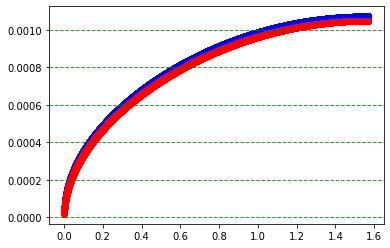

In [ ]:
fig = plt.figure()
ax = fig.subplot(1, 1, 1)
ax.scatter(t_forward, flow_by_exp_list, c='blue')
ax.scatter(t_forward, flow_by_theory_list, c='red')
ax.grid(which = "major", axis = "y", color = "green", alpha = 0.8, linestyle = "--", linewidth = 1)
fig.show()